# Statistical measure of gyre strength

### Notebook setup

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 20) 
matplotlib.rc('ytick', labelsize = 20)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42873/status,
Dashboard: /proxy/42873/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36381,Workers: 7
Dashboard: /proxy/42873/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:41511,Total threads: 4
Dashboard: /proxy/45515/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38349,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session = cc.database.create_session(db)

In [5]:
expt = '025deg_jra55_ryf_control'

### Estimating streamfunction

In [6]:
ncoarse = 12

x_min = [-100, -250, -70, -220, -70, -250]
x_max = [ 10 , -100,  20, -80 ,  20, -80 ]
y_min = [ 20 ,  20 , -42 ,-37 , -80, -80 ]
y_max = [ 75 ,  75 , -20, -20 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP', 'WG', 'RG']

k = 0

In [7]:
start_time = '2297-01-01'
end_time = '2301-12-31'

In [11]:
#area_u = cc.querying.getvar(expt = expt, session = session, variable = 'area_u', n = -1)
#T = cc.querying.getvar(expt = expt, session = session, variable = 'temp', n = -1).mean('time').isel(st_ocean = 0)
rho0 = 1026
pt_max = 1036
#max_val = np.zeros((end_year - start_year, np.size(expt)))

diff = 9
ty_trans_rho = cc.querying.getvar(expt = expt, session = session, variable = 'ty_trans_rho', frequency = '1 monthly', 
                                  start_time = start_time, end_time = end_time, use_cftime = True).sel(time = slice(start_time, end_time))
ty_trans_rho = ty_trans_rho.sel(potrho = slice(1028, pt_max))
ty_basin = ty_trans_rho.sel(grid_xt_ocean = slice(x_min[k], x_max[k])).sel(grid_yu_ocean = slice(y_min[k], y_max[k]))
psi_basin = ty_basin.cumsum('grid_xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

In [12]:
area_t = cc.querying.getvar(expt = expt, session = session, variable = 'area_t', n = 1).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
area_u = cc.querying.getvar(expt = expt, session = session, variable = 'area_u', n = 1).sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
T = cc.querying.getvar(expt = expt, session = session, variable = 'surface_temp', n = 1).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
T = T.mean('time')

In [13]:
psi = psi_basin.mean('time').sum('potrho')
psi = psi.rename('Subtropical gyre streamfunction')
psi = psi.rename({'grid_xt_ocean': 'xt_ocean','grid_yu_ocean': 'yu_ocean'})

paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
data = xr.merge((psi, area_t, area_u))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)

g = xgcm.Grid(data, periodic = ['Y'])
psi_intp = g.interp(psi, 'Y')

psi_intp = (psi_intp * T)/T
psi_intp = psi_intp.rename('Subtropical gyre streamfunction')

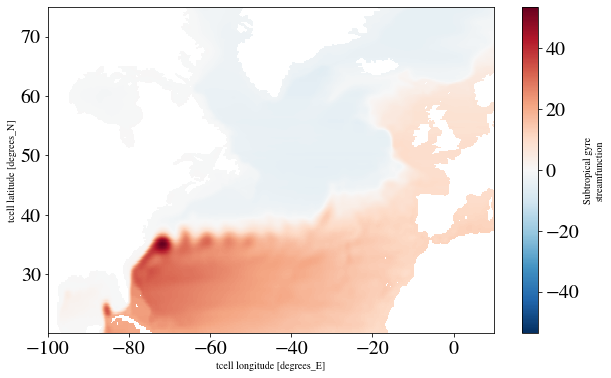

In [15]:
plt.figure(figsize = (10, 6))
psi_intp.plot()

### Getting the probabiliy density function

In [11]:
bmin = 0
bmax = 100
bins = np.linspace(bmin, bmax, (bmax - bmin + 1))

area_t = area_t.fillna(0)

from sklearn import preprocessing
area_t_normalize = preprocessing.normalize(area_t)
area_t_normalize = (area_t_normalize * T)/T

Text(0.5, 1.0, 'Area weighted histogram of North Atlantic gyre streamfunction')

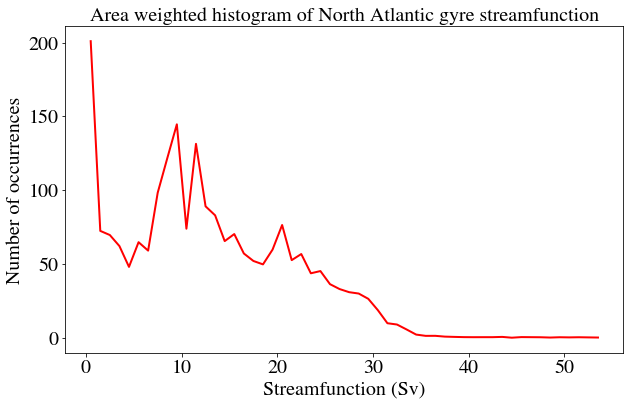

In [12]:
from xhistogram.xarray import histogram

whist = histogram(psi_intp, bins = bins, weights = area_t_normalize)
whist = whist.where(whist > 0, drop = True)

whist = whist.rename({'Subtropical gyre streamfunction_bin': 'bin'})

plt.figure(figsize = (10, 6))
whist.plot(color = 'red')
plt.xlabel('Streamfunction (Sv)', fontsize = 20)
plt.ylabel('Number of occurrences', fontsize = 20)
plt.title('Area weighted histogram of North Atlantic gyre streamfunction', fontsize = 20)

### Finding nth percentile

In [13]:
y_shape, x_shape = psi_intp.shape

psi_chunked = psi_intp.chunk(chunks={'yt_ocean':y_shape, 'xt_ocean':x_shape}).persist()
psi_chunked.quantile(0.99, dim = {"xt_ocean", "yt_ocean"}).values

array(30.49413269)